# 使用LSTM解决问题

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
device = "cuda:2"

In [2]:
# 1. 引入数据
path = '/mnt/data1/wlc_dataset/dataset/ETTh1.csv'
df = pd.read_csv(path,parse_dates=['date'],index_col = 'date')
print(df.shape) # [rows,features]->其中features为7
print(df.columns)

(17420, 7)
Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


In [3]:
## 统一标准化
# 使用2016.7-2017.6 的数据统计量对全部数据进行z-score标准化
train_base = df['2016-07-01':'2017-06-30']
mu,sigma = train_base.mean(),train_base.std()
df_norm = (df-mu) / sigma
df_full = df.copy()

In [4]:
## 数据构造
"""
历史窗口：336小时 -> 14 * 24
预测窗口：24小时
"""
# 按照小时为单位
"""
X[i] = {x_{i-look_back+1},...,x_i}
Y[i] = {x_{i+1},...,x_{i+horizon}}
"""
from torch.utils.data import Dataset

class SeqDataset(Dataset):
    def __init__(self,data,look_back,horizon):
        arr = data.values
        self.X = []
        self.Y = []
        for i in range(len(arr)- look_back-horizon):
            self.X.append(arr[i:i+look_back])
            self.Y.append(arr[i+look_back:i+look_back+horizon])
        self.X = np.stack(self.X) #[N,look_back,D]
        self.Y = np.stack(self.Y) #[N,horizon,D]
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return torch.FloatTensor(self.X[idx]),torch.FloatTensor(self.Y[idx])

## 模型架构
使用多层LSTM回归器
输入： [batch_size,look_back,num_features]
输出：[batch_size,horizon,num_targets]
由于当前看的是油温，所以num_targets = 1
"""
涉及到的超参数： hidden_num：隐藏状态向量的维度，常用的是64
dropout:0.2
"""

In [5]:
class LSTMForecaster(nn.Module):
    def __init__(self,input_dim,hidden_dim=64,
                 num_layers = 2,horizon=24,dropout=0.2):
        super(LSTMForecaster,self).__init__()
        self.lstm = nn.LSTM(input_dim,hidden_dim,
                            num_layers,batch_first = True,dropout=dropout)
        # 其中batch_first为True说明使用(batch,seq,feature)
        self.proj = nn.Linear(hidden_dim,horizon) # 将hidden_num映射到horizon
    
    def forward(self,x):
        out,_ = self.lstm(x)
        h_T = out[:,-1,:]
        y = self.proj(h_T)
        return y.unsqueeze(-1) # 维度扩展到[b,horizon,1]

## 训练

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
model = LSTMForecaster(input_dim=df.shape[1],hidden_dim=128,
                      num_layers=2,horizon=24,dropout=0.2)
model = model.to(device)

In [20]:
# 递归预测
# 写成一个方法了哈
from sklearn.metrics import mean_squared_error,mean_absolute_error
def train_and_roll(model,df_norm,df_full,device):
    # 使用adam优化器
    optimizer = optim.Adam(model.parameters(),lr = 1e-3)
    criterion = nn.MSELoss()
    ## 训练
    # 滚动预测起点 : 2017-6-30 23:00
    train_end = pd.Timestamp('2017-06-30 23:00:00')
    records = []
    # 滚动天数为一个月，由于有的月不是30天，使用MonthEnd
    # 每次都是按月进行滚动
    # 预测区间
    # pd.offsets.MonthEnd(1) 表示当前日期所在月有多少天；pd.offsets.MonthEnd(1)表示跳到当前月的月末
    while train_end + pd.offsets.MonthEnd(1) <= df_norm.index[-1]:
        # 数据集
        train_df = df_norm[:train_end] # 得到截止之前的所有数据
        ds = SeqDataset(train_df,look_back=336,horizon=24)
        loader = DataLoader(ds,batch_size=32,shuffle=True)
        # 训练
        model.train()
        for epoch in range(10):
            for xb,yb in loader:
                xb,yb = xb.to(device),yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred,yb)
                loss.backward()
                optimizer.step()
            print("epoch %d,loss:%.4f"%(epoch,loss.item()))
        model.eval()
        # 定义本轮需要预测的区间
        # 会看14天(336小时)来预测未来24小时
        test_start = train_end + pd.Timedelta(hours = 1)
        test_end = train_end + pd.offsets.MonthEnd(1)
        # 当月真实序列
        true_series = df_full.loc[test_start:test_end,'OT'].values
        # 回看序列
        hist_start = train_end - pd.Timedelta(hours = 336 -1)
        hist_df = df_norm.loc[hist_start:train_end]
        hist = torch.FloatTensor(hist_df.values).unsqueeze(0).to(device)
        # 预测
        preds = []
        #接下来预测一个月
        total_hours = len(true_series)
        days = total_hours // 24 # 完整的天数
        for day in range(days): # 循环20次，每次预测未来一天
            with torch.no_grad():
                out = model(hist)
            out_np = out.squeeze().cpu().numpy()
            # 存储与测试
            preds.extend(out_np)
            # 构建当前天的时间索引，为了将预测值写会DataFrame
            start_hour = test_start + pd.Timedelta(days = day)
            idx = pd.date_range(
                start = start_hour,
                periods = 24,
                freq = 'H'
            )
            fut_df = df_norm.loc[idx].copy()
            fut_df['OT'] = out_np
            # 更新hist矩阵
            # 去掉之前的24个小时，预测新的24小时
            hist_np = hist.squeeze(0).cpu().numpy()
            updated = np.vstack([hist_np[24:],fut_df.values])
            hist = torch.FloatTensor(updated).unsqueeze(0).to(device)
        # 反标准化
        preds = np.array(preds)
        preds_denorm = preds * sigma['OT'] + mu['OT']
        mse = mean_squared_error(true_series,preds_denorm)
        mae = mean_absolute_error(true_series,preds_denorm)
        #需要真实和预测的平均值
        rmse = np.sqrt(mse)
        true_mean = true_series.mean()
        pred_mean = preds_denorm.mean()
        records.append({
            'end':train_end,
            'MSE':mse,
            'MAE':mae,
            'true_mean':true_mean,
            'pred_mean':pred_mean,
            'RMSE':rmse,
        })
        print(f"rolled until {test_end.date()}: MSE={mse:.4f}, MAE={mae:.4f}")
        # 下一个月
        train_end = test_end
    return records

In [21]:
records = train_and_roll(model,df_norm,df_full,device)

/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 7])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7018
epoch 1,loss:0.6968
epoch 2,loss:0.5732
epoch 3,loss:0.6234
epoch 4,loss:0.7879
epoch 5,loss:0.7035
epoch 6,loss:0.5633
epoch 7,loss:0.8246
epoch 8,loss:0.5244
epoch 9,loss:0.5463
rolled until 2017-07-31: MSE=49.5305, MAE=6.1216


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 7])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7002
epoch 1,loss:0.6661
epoch 2,loss:0.6111
epoch 3,loss:0.5425
epoch 4,loss:0.6019
epoch 5,loss:0.8670
epoch 6,loss:0.6183
epoch 7,loss:0.5838
epoch 8,loss:0.7368
epoch 9,loss:0.6484
rolled until 2017-08-31: MSE=32.0500, MAE=4.6314


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6417
epoch 1,loss:0.8675
epoch 2,loss:0.7712
epoch 3,loss:0.7141
epoch 4,loss:0.7669
epoch 5,loss:0.7047
epoch 6,loss:0.7396
epoch 7,loss:0.7958
epoch 8,loss:0.7426
epoch 9,loss:0.6894
rolled until 2017-09-30: MSE=15.4586, MAE=3.2419


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 7])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6870
epoch 1,loss:0.5753
epoch 2,loss:0.9649
epoch 3,loss:0.6603
epoch 4,loss:0.6470
epoch 5,loss:1.0025
epoch 6,loss:0.4708
epoch 7,loss:0.8951
epoch 8,loss:0.8466
epoch 9,loss:0.7510
rolled until 2017-10-31: MSE=55.1114, MAE=6.1318


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 7])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7773
epoch 1,loss:0.5132
epoch 2,loss:1.0452
epoch 3,loss:0.8109
epoch 4,loss:0.8135
epoch 5,loss:1.0116
epoch 6,loss:0.6230
epoch 7,loss:0.8171
epoch 8,loss:0.5999
epoch 9,loss:0.7726
rolled until 2017-11-30: MSE=103.7801, MAE=9.0104


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 24, 7])) that is different to the input size (torch.Size([8, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.5391
epoch 1,loss:0.6514
epoch 2,loss:0.5609
epoch 3,loss:0.7009
epoch 4,loss:0.7689
epoch 5,loss:1.0202
epoch 6,loss:0.5728
epoch 7,loss:0.9086
epoch 8,loss:0.6006
epoch 9,loss:0.7237
rolled until 2017-12-31: MSE=170.3038, MAE=12.2341


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 7])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6048
epoch 1,loss:1.1934
epoch 2,loss:0.6960
epoch 3,loss:0.5982
epoch 4,loss:0.6672
epoch 5,loss:0.6449
epoch 6,loss:0.7052
epoch 7,loss:0.8605
epoch 8,loss:0.7782
epoch 9,loss:0.8558
rolled until 2018-01-31: MSE=289.9641, MAE=16.6256


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 7])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.8341
epoch 1,loss:0.9155
epoch 2,loss:0.8606
epoch 3,loss:0.7676
epoch 4,loss:0.6423
epoch 5,loss:0.9396
epoch 6,loss:0.8052
epoch 7,loss:0.6119
epoch 8,loss:0.7970
epoch 9,loss:0.6752
rolled until 2018-02-28: MSE=192.5097, MAE=12.9259


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 7])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.8066
epoch 1,loss:0.8629
epoch 2,loss:0.6318
epoch 3,loss:0.6106
epoch 4,loss:0.8353
epoch 5,loss:0.6948
epoch 6,loss:0.6613
epoch 7,loss:0.9342
epoch 8,loss:0.7469
epoch 9,loss:0.6983
rolled until 2018-03-31: MSE=119.3026, MAE=9.8267


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7456
epoch 1,loss:0.7668
epoch 2,loss:0.6325
epoch 3,loss:0.7571
epoch 4,loss:0.6872
epoch 5,loss:0.6798
epoch 6,loss:0.7341
epoch 7,loss:0.7962
epoch 8,loss:0.7983
epoch 9,loss:0.7300
rolled until 2018-04-30: MSE=64.3586, MAE=6.7951


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 7])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 7])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.9056
epoch 1,loss:0.8447
epoch 2,loss:0.4761
epoch 3,loss:0.6814
epoch 4,loss:0.6834
epoch 5,loss:0.7275
epoch 6,loss:0.6791
epoch 7,loss:0.6267
epoch 8,loss:0.7100
epoch 9,loss:0.6998
rolled until 2018-05-31: MSE=62.8439, MAE=6.5622


/tmp/ipykernel_2889264/597771390.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(


In [35]:
# 转换为datafram
rec_df = pd.DataFrame(records)
rec_df['month'] = rec_df['end'].dt.to_period('M').astype(str)
rec_df

,end,MSE,MAE,true_mean,pred_mean,RMSE,month
0,2017-06-30 23:00:00,49.530522,6.121562,21.036007,17.422277,7.037792,2017-06
1,2017-07-31 23:00:00,32.049962,4.631414,16.154098,19.286594,5.661269,2017-07
2,2017-08-31 23:00:00,15.458644,3.241890,13.303906,13.216787,3.931748,2017-08
3,2017-09-30 23:00:00,55.111389,6.131824,9.537890,14.964231,7.423705,2017-09
4,2017-10-31 23:00:00,103.780077,9.010385,7.445742,16.291985,10.187251,2017-10
5,2017-11-30 23:00:00,170.303779,12.234055,4.415702,16.640041,13.050049,2017-11
6,2017-12-31 23:00:00,289.964094,16.625612,2.376293,19.001905,17.028332,2017-12
7,2018-01-31 23:00:00,192.509661,12.925908,3.838289,16.763611,13.874785,2018-01
8,2018-02-28 23:00:00,119.302619,9.826676,6.667909,16.453579,10.922574,2018-02
9,2018-03-31 23:00:00,64.358639,6.795132,8.226892,14.652291,8.022384,2018-03


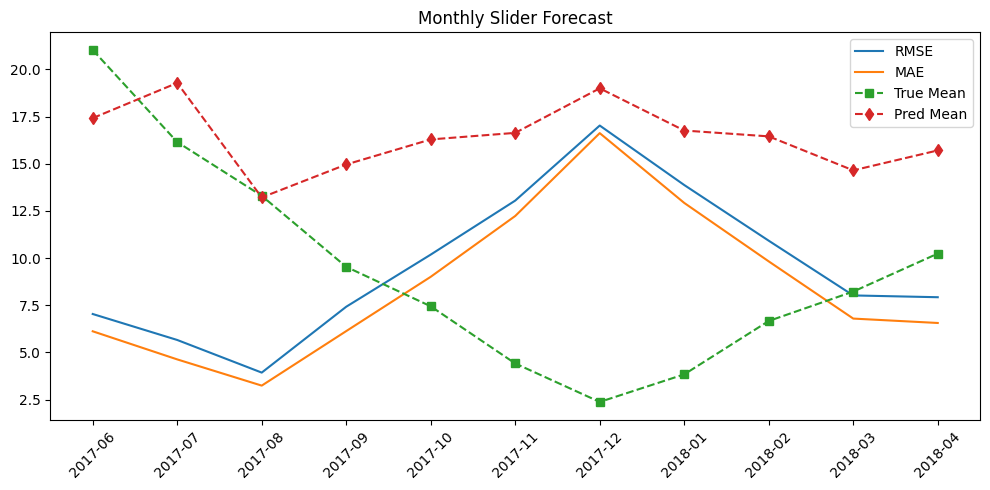

In [25]:
# 进行可视化
"""
有要求：
添加预测值和真实值
"""
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
# 1. 误差曲线
# plt.plot(rec_df['month'],rec_df['MSE'],label = 'MSE')
plt.plot(rec_df['month'],rec_df['RMSE'],label = 'RMSE')
plt.plot(rec_df['month'],rec_df['MAE'],label = 'MAE')
# 2. 真实 vs 预测平均值！
plt.plot(rec_df['month'],rec_df['true_mean'],label = 'True Mean',linestyle='--',marker = 's')
plt.plot(rec_df['month'], rec_df['pred_mean'], label='Pred Mean', linestyle='--', marker='d')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Monthly Slider Forecast")
plt.tight_layout()
plt.show()

## 在LSTM的基础上添加偏置项


In [60]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
def train_and_roll_bias(model,df_norm,df_full,device,lambda_bias=0.1):
    # 使用adam优化器
    optimizer = optim.Adam(model.parameters(),lr = 1e-3)
    criterion = nn.MSELoss()
    ## 训练
    # 滚动预测起点 : 2017-6-30 23:00
    train_end = pd.Timestamp('2017-06-30 23:00:00')
    records = []
    # 滚动天数为一个月，由于有的月不是30天，使用MonthEnd
    # 每次都是按月进行滚动
    # 预测区间
    # pd.offsets.MonthEnd(1) 表示当前日期所在月有多少天；pd.offsets.MonthEnd(1)表示跳到当前月的月末
    while train_end + pd.offsets.MonthEnd(1) <= df_norm.index[-1]:
        # 数据集
        train_df = df_norm[:train_end] # 得到截止之前的所有数据
        ds = SeqDataset(train_df,look_back=336,horizon=24)
        loader = DataLoader(ds,batch_size=32,shuffle=True)
        # 训练
        model.train()
        for epoch in range(10):
            for xb,yb in loader:
                xb,yb = xb.to(device),yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss_mse = criterion(pred,yb)
                # 计算平均偏差项：每个样本时间维度的平均误差，然后平方并在batch上求平均
                bias_per_sample = (yb-pred).mean(dim=1)
                loss_bias = (bias_per_sample**2).mean()
                loss = loss_mse + lambda_bias * loss_bias
                loss.backward()
                optimizer.step()
            print("epoch %d,loss:%.4f"%(epoch,loss.item()))
        model.eval()
        # 定义本轮需要预测的区间
        # 会看14天(336小时)来预测未来24小时
        test_start = train_end + pd.Timedelta(hours = 1)
        test_end = train_end + pd.offsets.MonthEnd(1)
        # 当月真实序列
        true_series = df_full.loc[test_start:test_end,'OT'].values
        # 回看序列
        hist_start = train_end - pd.Timedelta(hours = 336 -1)
        hist_df = df_norm.loc[hist_start:train_end]
        hist = torch.FloatTensor(hist_df.values).unsqueeze(0).to(device)
        # 预测
        preds = []
        #接下来预测一个月
        total_hours = len(true_series)
        days = total_hours // 24 # 完整的天数
        for day in range(days): # 循环20次，每次预测未来一天
            with torch.no_grad():
                out = model(hist)
            out_np = out.squeeze().cpu().numpy()
            # 存储与测试
            preds.extend(out_np)
            # 构建当前天的时间索引，为了将预测值写会DataFrame
            start_hour = test_start + pd.Timedelta(days = day)
            idx = pd.date_range(
                start = start_hour,
                periods = 24,
                freq = 'H'
            )
            fut_df = df_norm.loc[idx].copy()
            fut_df['OT'] = out_np
            # 更新hist矩阵
            # 去掉之前的24个小时，预测新的24小时
            hist_np = hist.squeeze(0).cpu().numpy()
            updated = np.vstack([hist_np[24:],fut_df.values])
            hist = torch.FloatTensor(updated).unsqueeze(0).to(device)
        # 反标准化
        preds = np.array(preds)
        preds_denorm = preds * sigma['OT'] + mu['OT']
        # 原单位
        mse = mean_squared_error(true_series,preds_denorm)
        mae = mean_absolute_error(true_series,preds_denorm)
        #需要真实和预测的平均值
        true_mean = true_series.mean()
        pred_mean = preds_denorm.mean()
        rmse = np.sqrt(mse)  # 加上这一句
        records.append({
            'end':train_end,
            'MSE':mse,
            'MAE':mae,
            'true_mean':true_mean,
            'pred_mean':pred_mean,
            'RMSE':rmse,
        })
        print(f"rolled until {test_end.date()}: MSE={mse:.4f}, MAE={mae:.4f}")
        # 下一个月
        train_end = test_end
    return records

In [61]:
model_bias = LSTMForecaster(input_dim=df.shape[1],hidden_dim=128,
                      num_layers=2,horizon=24,dropout=0.2).to(device)
records_bias = train_and_roll_bias(model_bias,df_norm,df_full,device,lambda_bias=0.1)

RuntimeError: input.size(-1) must be equal to input_size. Expected 19, got 6

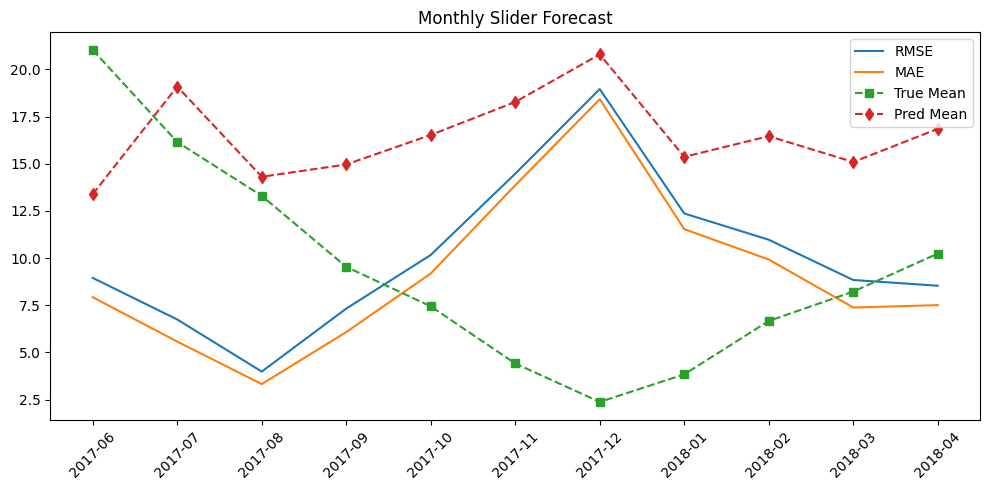

In [ ]:
# 转换为datafram
rec_df = pd.DataFrame(records_bias)
rec_df['month'] = rec_df['end'].dt.to_period('M').astype(str)
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
# 1. 误差曲线
# plt.plot(rec_df['month'],rec_df['MSE'],label = 'MSE')
plt.plot(rec_df['month'],rec_df['RMSE'],label = 'RMSE')
plt.plot(rec_df['month'],rec_df['MAE'],label = 'MAE')
# 2. 真实 vs 预测平均值！
plt.plot(rec_df['month'],rec_df['true_mean'],label = 'True Mean',linestyle='--',marker = 's')
plt.plot(rec_df['month'], rec_df['pred_mean'], label='Pred Mean', linestyle='--', marker='d')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Monthly Slider Forecast")
plt.tight_layout()
plt.show()

In [40]:
rec_df

,end,MSE,MAE,true_mean,pred_mean,RMSE,month
0,2017-06-30 23:00:00,77.006974,8.011235,21.036007,13.138647,8.775362,2017-06
1,2017-07-31 23:00:00,43.242919,5.243259,16.154098,18.861013,6.575935,2017-07
2,2017-08-31 23:00:00,18.815192,3.593426,13.303906,14.014829,4.337648,2017-08
3,2017-09-30 23:00:00,57.663338,6.315617,9.537890,15.234064,7.593638,2017-09
4,2017-10-31 23:00:00,107.575001,9.494682,7.445742,16.890188,10.371837,2017-10
5,2017-11-30 23:00:00,286.238690,16.492594,4.415702,20.908297,16.918590,2017-11
6,2017-12-31 23:00:00,399.042113,19.511197,2.376293,21.887491,19.976038,2017-12
7,2018-01-31 23:00:00,199.570512,13.170469,3.838289,16.998396,14.126943,2018-01
8,2018-02-28 23:00:00,105.053652,9.266638,6.667909,15.883823,10.249568,2018-02
9,2018-03-31 23:00:00,70.337967,7.114717,8.226892,15.065170,8.386773,2018-03


In [43]:
## 添加时间特征
# 5个变量：hour_sin,hour_cos,month_sin,month_cos
# 1️⃣ 添加时间字段（基于索引）
df_norm['hour'] = df_norm.index.hour
df_norm['month'] = df_norm.index.month
df_norm['weekday'] = df_norm.index.weekday
#df_norm['is_weekend'] = (df_norm['weekday'] >= 5).astype(int)

# 2️⃣ 添加周期编码
df_norm['hour_sin'] = np.sin(2 * np.pi * df_norm['hour'] / 24)
df_norm['hour_cos'] = np.cos(2 * np.pi * df_norm['hour'] / 24)
df_norm['month_sin'] = np.sin(2 * np.pi * df_norm['month'] / 12)
df_norm['month_cos'] = np.cos(2 * np.pi * df_norm['month'] / 12)

# 3️⃣ 只保留必要列（原始特征 + 时间特征）
df_norm = df_norm[[
    'OT',                    # 原始目标值（已标准化）
    'hour_sin', 'hour_cos', # 日内周期
    'month_sin', 'month_cos', # 季节性
    # 'is_weekend'            # 可选辅助
    # 你还可以加其他变量：风速、气压等
]]

In [45]:
model_time = LSTMForecaster(input_dim=df_norm.shape[1],hidden_dim=128,
                      num_layers=2,horizon=24,dropout=0.2).to(device)
records_time = train_and_roll_bias(model_time,df_norm,df_full,device,lambda_bias=0.5)

/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 5])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7019
epoch 1,loss:0.7538
epoch 2,loss:0.7442
epoch 3,loss:0.8342
epoch 4,loss:0.7448
epoch 5,loss:0.7577
epoch 6,loss:0.7383
epoch 7,loss:0.6569
epoch 8,loss:0.7252
epoch 9,loss:0.6904
rolled until 2017-07-31: MSE=51.3926, MAE=6.4254


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 5])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6022
epoch 1,loss:0.8636
epoch 2,loss:0.7684
epoch 3,loss:0.6764
epoch 4,loss:0.6944
epoch 5,loss:0.8521
epoch 6,loss:0.7207
epoch 7,loss:0.9867
epoch 8,loss:0.5980
epoch 9,loss:0.8120
rolled until 2017-08-31: MSE=17.1840, MAE=3.2844


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7051
epoch 1,loss:0.7146
epoch 2,loss:0.6859
epoch 3,loss:0.7662
epoch 4,loss:0.6629
epoch 5,loss:0.5652
epoch 6,loss:0.6318
epoch 7,loss:0.6306
epoch 8,loss:0.6967
epoch 9,loss:0.5935
rolled until 2017-09-30: MSE=13.6434, MAE=3.0384


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 5])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6415
epoch 1,loss:0.7524
epoch 2,loss:0.7091
epoch 3,loss:0.7272
epoch 4,loss:0.5879
epoch 5,loss:0.8692
epoch 6,loss:0.6599
epoch 7,loss:0.7707
epoch 8,loss:0.6702
epoch 9,loss:0.5873
rolled until 2017-10-31: MSE=62.8752, MAE=7.1828


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 5])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6831
epoch 1,loss:0.6688
epoch 2,loss:0.6081
epoch 3,loss:0.7299
epoch 4,loss:0.6389
epoch 5,loss:0.6571
epoch 6,loss:0.6566
epoch 7,loss:0.6293
epoch 8,loss:0.5856
epoch 9,loss:0.7358
rolled until 2017-11-30: MSE=117.9571, MAE=10.2300


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 24, 5])) that is different to the input size (torch.Size([8, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6659
epoch 1,loss:0.7500
epoch 2,loss:0.7646
epoch 3,loss:0.6116
epoch 4,loss:0.5184
epoch 5,loss:0.6990
epoch 6,loss:0.5119
epoch 7,loss:0.7063
epoch 8,loss:0.6990
epoch 9,loss:0.5378
rolled until 2017-12-31: MSE=165.8896, MAE=12.5831


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 5])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7980
epoch 1,loss:0.7387
epoch 2,loss:0.8143
epoch 3,loss:0.6362
epoch 4,loss:0.7121
epoch 5,loss:0.8963
epoch 6,loss:0.6664
epoch 7,loss:0.6034
epoch 8,loss:0.7258
epoch 9,loss:0.6009
rolled until 2018-01-31: MSE=221.1793, MAE=14.5072


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 5])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7052
epoch 1,loss:0.7081
epoch 2,loss:0.7010
epoch 3,loss:0.6706
epoch 4,loss:0.8981
epoch 5,loss:0.7025
epoch 6,loss:0.6756
epoch 7,loss:0.6604
epoch 8,loss:0.6353
epoch 9,loss:0.6042
rolled until 2018-02-28: MSE=190.6278, MAE=13.5372


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 5])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7155
epoch 1,loss:0.7230
epoch 2,loss:0.7110
epoch 3,loss:0.7408
epoch 4,loss:0.7206
epoch 5,loss:1.0018
epoch 6,loss:0.7760
epoch 7,loss:0.6216
epoch 8,loss:0.8176
epoch 9,loss:0.6053
rolled until 2018-03-31: MSE=135.6093, MAE=10.9289


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7651
epoch 1,loss:0.7784
epoch 2,loss:0.8077
epoch 3,loss:0.7882
epoch 4,loss:0.7920
epoch 5,loss:0.7200
epoch 6,loss:0.8143
epoch 7,loss:0.7002
epoch 8,loss:0.7804
epoch 9,loss:0.6751
rolled until 2018-04-30: MSE=111.4644, MAE=9.8510


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 5])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 5])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7273
epoch 1,loss:0.7255
epoch 2,loss:0.7602
epoch 3,loss:0.7765
epoch 4,loss:0.8193
epoch 5,loss:0.7361
epoch 6,loss:0.8530
epoch 7,loss:0.7589
epoch 8,loss:0.7502
epoch 9,loss:0.6457
rolled until 2018-05-31: MSE=52.3344, MAE=6.5254


/tmp/ipykernel_2889264/2282105694.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(


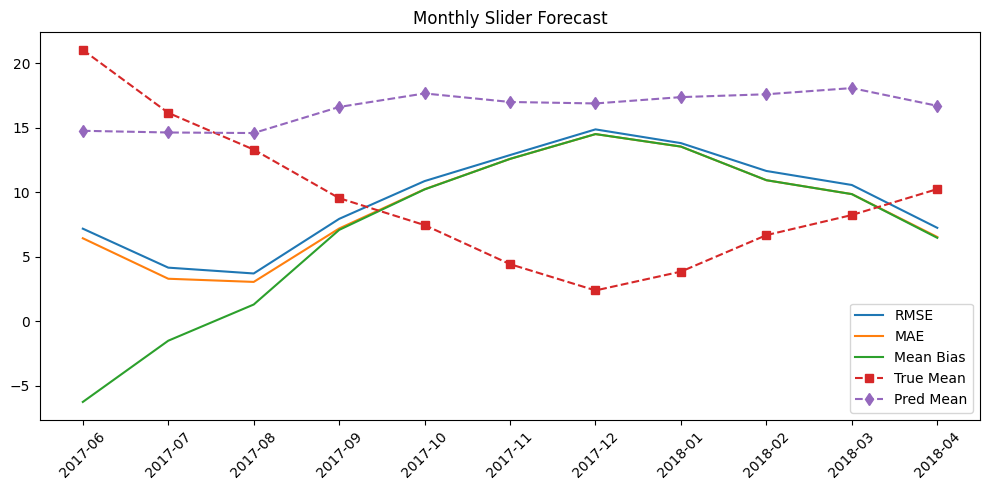

In [ ]:
# 转换为datafram
rec_df = pd.DataFrame(records_time)
rec_df['month'] = rec_df['end'].dt.to_period('M').astype(str)
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
# 1. 误差曲线
# plt.plot(rec_df['month'],rec_df['MSE'],label = 'MSE')
plt.plot(rec_df['month'],rec_df['RMSE'],label = 'RMSE')
plt.plot(rec_df['month'],rec_df['MAE'],label = 'MAE')
rec_df['mean_bias'] = rec_df['pred_mean'] - rec_df['true_mean']
plt.plot(rec_df['month'], rec_df['mean_bias'], label='Mean Bias')
# 2. 真实 vs 预测平均值！
plt.plot(rec_df['month'],rec_df['true_mean'],label = 'True Mean',linestyle='--',marker = 's')
plt.plot(rec_df['month'], rec_df['pred_mean'], label='Pred Mean', linestyle='--', marker='d')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Monthly Slider Forecast")
plt.tight_layout()
plt.show()

In [49]:
rec_df

,end,MSE,MAE,true_mean,pred_mean,RMSE,month,mean_bias
0,2017-06-30 23:00:00,51.392627,6.425426,21.036007,14.762271,7.168865,2017-06,-6.273736
1,2017-07-31 23:00:00,17.184040,3.284421,16.154098,14.631128,4.145364,2017-07,-1.522970
2,2017-08-31 23:00:00,13.643372,3.038447,13.303906,14.588080,3.693694,2017-08,1.284175
3,2017-09-30 23:00:00,62.875166,7.182767,9.537890,16.610703,7.929386,2017-09,7.072813
4,2017-10-31 23:00:00,117.957115,10.229963,7.445742,17.660362,10.860806,2017-10,10.214621
5,2017-11-30 23:00:00,165.889617,12.583064,4.415702,16.998764,12.879814,2017-11,12.583062
6,2017-12-31 23:00:00,221.179323,14.507162,2.376293,16.883455,14.872099,2017-12,14.507162
7,2018-01-31 23:00:00,190.627830,13.537210,3.838289,17.375498,13.806804,2018-01,13.537209
8,2018-02-28 23:00:00,135.609273,10.928867,6.667909,17.596775,11.645139,2018-02,10.928866
9,2018-03-31 23:00:00,111.464378,9.850991,8.226892,18.076372,10.557669,2018-03,9.849480


## 使用趋势分析

In [50]:
# 使用STL分解
from statsmodels.tsa.seasonal import STL
stl = STL(df['OT'],period = 24 * 30)
res = stl.fit()
# 拆分得到趋势、季节性、残差
df['OT_trend'] = res.trend
df['OT_seasonal'] = res.seasonal
df['OT_resid'] = res.resid
# 标准化残差
mu = df['OT_resid'].mean()
sigma = df['OT_resid'].std()
df['OT_resid_norm'] = (df['OT_resid'] - mu) / sigma

# 添加时间特征
df['hour'] = df.index.hour
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df_full = df.copy()
# 构建嘴中训练用数据
features = [
    'OT_resid_norm',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos',
    'is_weekend'
]
df_norm = df[features].copy()

In [51]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
def train_and_roll_stl(model,df_norm,df_full,device,lambda_bias=0.1):
    # 使用adam优化器
    optimizer = optim.Adam(model.parameters(),lr = 1e-3)
    criterion = nn.MSELoss()
    ## 训练
    # 滚动预测起点 : 2017-6-30 23:00
    train_end = pd.Timestamp('2017-06-30 23:00:00')
    records = []
    while train_end + pd.offsets.MonthEnd(1) <= df_norm.index[-1]:
        # 数据集
        train_df = df_norm[:train_end] # 得到截止之前的所有数据
        ds = SeqDataset(train_df,look_back=336,horizon=24)
        loader = DataLoader(ds,batch_size=32,shuffle=True)
        # 训练
        model.train()
        for epoch in range(10):
            for xb,yb in loader:
                xb,yb = xb.to(device),yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss_mse = criterion(pred,yb)
                # 计算平均偏差项：每个样本时间维度的平均误差，然后平方并在batch上求平均
                bias_per_sample = (yb-pred).mean(dim=1)
                loss_bias = (bias_per_sample**2).mean()
                loss = loss_mse + lambda_bias * loss_bias
                loss.backward()
                optimizer.step()
            print("epoch %d,loss:%.4f"%(epoch,loss.item()))
        model.eval()
        # 定义本轮需要预测的区间
        # 会看14天(336小时)来预测未来24小时
        test_start = train_end + pd.Timedelta(hours = 1)
        test_end = train_end + pd.offsets.MonthEnd(1)
        # 当月真实序列
        true_series = df_norm.loc[test_start:test_end,'OT_resid_norm'].values
        # 回看序列
        hist_start = train_end - pd.Timedelta(hours = 336 -1)
        hist_df = df_norm.loc[hist_start:train_end]
        hist = torch.FloatTensor(hist_df.values).unsqueeze(0).to(device)
        # 预测
        preds = []
        #接下来预测一个月
        total_hours = len(true_series)
        days = total_hours // 24 # 完整的天数
        for day in range(days): # 循环20次，每次预测未来一天
            with torch.no_grad():
                out = model(hist)
            out_np = out.squeeze().cpu().numpy()
            # 存储与测试
            preds.extend(out_np)
            # 构建当前天的时间索引，为了将预测值写会DataFrame
            start_hour = test_start + pd.Timedelta(days = day)
            idx = pd.date_range(
                start = start_hour,
                periods = 24,
                freq = 'H'
            )
            fut_df = df_norm.loc[idx].copy()
            fut_df['OT_resid_norm'] = out_np
            # 更新hist矩阵
            # 去掉之前的24个小时，预测新的24小时
            hist_np = hist.squeeze(0).cpu().numpy()
            updated = np.vstack([hist_np[24:],fut_df.values])
            hist = torch.FloatTensor(updated).unsqueeze(0).to(device)
        # 残差还原
        preds_denorm = np.array(preds) * sigma + mu

        # 加回趋势和季节性（用原始 df_full ）
        trend_part = df_full.loc[test_start:test_end, 'OT_trend'].values
        season_part = df_full.loc[test_start:test_end, 'OT_seasonal'].values
        final_preds = preds_denorm + trend_part + season_part

        # 真值
        true_full = df_full.loc[test_start:test_end, 'OT'].values

        # 评估指标
        mse = mean_squared_error(true_full, final_preds)
        mae = mean_absolute_error(true_full, final_preds)
        rmse = np.sqrt(mse)

        records.append({
            'end': train_end,
            'MSE': mse,
            'MAE': mae,
            'true_mean': true_full.mean(),
            'pred_mean': final_preds.mean(),
            'RMSE': rmse,
        })

        print(f"rolled until {test_end.date()}: MSE={mse:.4f}, MAE={mae:.4f}")

        # 滚动更新
        train_end = test_end

    return records

In [59]:
model_stl = LSTMForecaster(input_dim=df_norm.shape[1],hidden_dim=128,
                      num_layers=2,horizon=24,dropout=0.2).to(device)
records_stl = train_and_roll_stl(model_stl,df_norm,df_full,device,lambda_bias=0.5)

/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 6])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7314
epoch 1,loss:0.6573
epoch 2,loss:0.6612
epoch 3,loss:0.6112


epoch 4,loss:0.4891
epoch 5,loss:0.6477
epoch 6,loss:0.9192
epoch 7,loss:0.6048
epoch 8,loss:0.7695
epoch 9,loss:0.7199
rolled until 2017-07-31: MSE=4.8367, MAE=1.7724


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 6])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7233
epoch 1,loss:0.6009
epoch 2,loss:0.6335
epoch 3,loss:0.7886
epoch 4,loss:0.7173
epoch 5,loss:0.6265
epoch 6,loss:0.6232
epoch 7,loss:0.6598
epoch 8,loss:0.6988
epoch 9,loss:0.6236
rolled until 2017-08-31: MSE=3.6695, MAE=1.4970


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.7028
epoch 1,loss:0.6468
epoch 2,loss:0.6621
epoch 3,loss:0.7347
epoch 4,loss:0.5998
epoch 5,loss:0.5337
epoch 6,loss:0.5652
epoch 7,loss:0.7912
epoch 8,loss:0.5348
epoch 9,loss:0.7491
rolled until 2017-09-30: MSE=4.6775, MAE=1.7986


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 6])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.5523
epoch 1,loss:0.6303
epoch 2,loss:0.7461
epoch 3,loss:0.5204
epoch 4,loss:0.6952
epoch 5,loss:0.6484
epoch 6,loss:0.4794
epoch 7,loss:0.7203
epoch 8,loss:0.6073
epoch 9,loss:0.6408
rolled until 2017-10-31: MSE=4.4910, MAE=1.6659


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 6])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6429
epoch 1,loss:0.6085
epoch 2,loss:0.6066
epoch 3,loss:0.6829
epoch 4,loss:0.5102
epoch 5,loss:0.6254
epoch 6,loss:0.5286
epoch 7,loss:0.5916
epoch 8,loss:0.6165
epoch 9,loss:0.6493
rolled until 2017-11-30: MSE=4.4212, MAE=1.7098


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 24, 6])) that is different to the input size (torch.Size([8, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.4392
epoch 1,loss:0.6791
epoch 2,loss:0.6903
epoch 3,loss:0.6232
epoch 4,loss:0.6201
epoch 5,loss:0.7535
epoch 6,loss:0.5973
epoch 7,loss:0.4715
epoch 8,loss:0.5184
epoch 9,loss:0.5605
rolled until 2017-12-31: MSE=2.3654, MAE=1.2026


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 6])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.5734
epoch 1,loss:0.6506
epoch 2,loss:0.5739
epoch 3,loss:0.5651
epoch 4,loss:0.5128
epoch 5,loss:0.5225
epoch 6,loss:0.6965
epoch 7,loss:0.6379
epoch 8,loss:0.8303
epoch 9,loss:0.6515
rolled until 2018-01-31: MSE=6.5327, MAE=2.0303


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 6])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6111
epoch 1,loss:0.5128
epoch 2,loss:0.5269
epoch 3,loss:0.6101
epoch 4,loss:0.5366
epoch 5,loss:0.6563
epoch 6,loss:0.6068
epoch 7,loss:0.5442
epoch 8,loss:0.6562
epoch 9,loss:0.6745
rolled until 2018-02-28: MSE=2.4440, MAE=1.2765


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 24, 6])) that is different to the input size (torch.Size([24, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6579
epoch 1,loss:0.6608
epoch 2,loss:0.6555
epoch 3,loss:0.6850
epoch 4,loss:0.5913
epoch 5,loss:0.5183
epoch 6,loss:0.5187
epoch 7,loss:0.5576
epoch 8,loss:0.5642
epoch 9,loss:0.5321
rolled until 2018-03-31: MSE=5.7865, MAE=2.0064


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6810
epoch 1,loss:0.6207
epoch 2,loss:0.5647
epoch 3,loss:0.6009
epoch 4,loss:0.6690
epoch 5,loss:0.6449
epoch 6,loss:0.5645
epoch 7,loss:0.6229
epoch 8,loss:0.5735
epoch 9,loss:0.5906
rolled until 2018-04-30: MSE=6.9303, MAE=2.1400


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 6])) that is different to the input size (torch.Size([32, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/buaadl/conda_envs/tinyllava/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 24, 6])) that is different to the input size (torch.Size([16, 24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0,loss:0.6145
epoch 1,loss:0.6219
epoch 2,loss:0.5765
epoch 3,loss:0.6316
epoch 4,loss:0.6151
epoch 5,loss:0.6149
epoch 6,loss:0.5369
epoch 7,loss:0.5100
epoch 8,loss:0.6162
epoch 9,loss:0.5807
rolled until 2018-05-31: MSE=3.8007, MAE=1.5954


/tmp/ipykernel_2889264/753341618.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(


                   end       MSE       MAE  true_mean  pred_mean      RMSE  \
0  2017-06-30 23:00:00  4.708232  1.741730  21.036007  19.878147  2.169846   
1  2017-07-31 23:00:00  3.703093  1.497329  16.154098  16.082413  1.924342   
2  2017-08-31 23:00:00  4.814484  1.823803  13.303906  12.647946  2.194193   
3  2017-09-30 23:00:00  4.390254  1.645309   9.537890   9.608352  2.095293   
4  2017-10-31 23:00:00  4.448397  1.726308   7.445742   7.975673  2.109122   
5  2017-11-30 23:00:00  2.747154  1.328888   4.415702   5.042476  1.657454   
6  2017-12-31 23:00:00  6.203919  1.981886   2.376293   3.668246  2.490767   
7  2018-01-31 23:00:00  2.428778  1.232593   3.838289   4.428372  1.558454   
8  2018-02-28 23:00:00  5.657345  1.993003   6.667909   7.035795  2.378517   
9  2018-03-31 23:00:00  6.990834  2.137423   8.226892   8.878096  2.644018   
10 2018-04-30 23:00:00  3.813629  1.582705  10.240676  10.309873  1.952851   

      month  
0   2017-06  
1   2017-07  
2   2017-08  
3   201

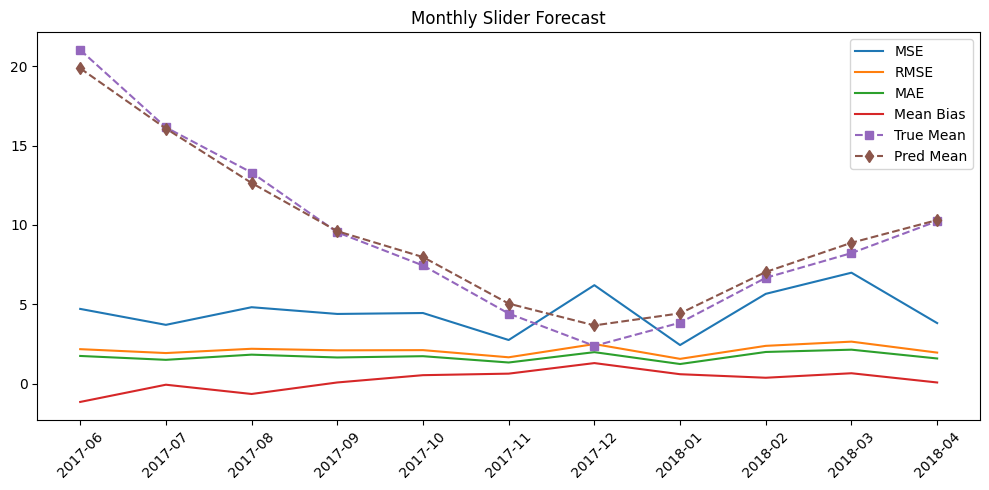

In [57]:
# 转换为datafram
rec_df = pd.DataFrame(records_stl)
rec_df['month'] = rec_df['end'].dt.to_period('M').astype(str)

print(rec_df)
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
# 1. 误差曲线
plt.plot(rec_df['month'],rec_df['MSE'],label = 'MSE')
plt.plot(rec_df['month'],rec_df['RMSE'],label = 'RMSE')
plt.plot(rec_df['month'],rec_df['MAE'],label = 'MAE')
rec_df['mean_bias'] = rec_df['pred_mean'] - rec_df['true_mean']
plt.plot(rec_df['month'], rec_df['mean_bias'], label='Mean Bias')
# 2. 真实 vs 预测平均值！
plt.plot(rec_df['month'],rec_df['true_mean'],label = 'True Mean',linestyle='--',marker = 's')
plt.plot(rec_df['month'], rec_df['pred_mean'], label='Pred Mean', linestyle='--', marker='d')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Monthly Slider Forecast")
plt.tight_layout()
plt.show()

In [58]:
rec_df

,end,MSE,MAE,true_mean,pred_mean,RMSE,month,mean_bias
0,2017-06-30 23:00:00,4.708232,1.741730,21.036007,19.878147,2.169846,2017-06,-1.157860
1,2017-07-31 23:00:00,3.703093,1.497329,16.154098,16.082413,1.924342,2017-07,-0.071685
2,2017-08-31 23:00:00,4.814484,1.823803,13.303906,12.647946,2.194193,2017-08,-0.655959
3,2017-09-30 23:00:00,4.390254,1.645309,9.537890,9.608352,2.095293,2017-09,0.070463
4,2017-10-31 23:00:00,4.448397,1.726308,7.445742,7.975673,2.109122,2017-10,0.529931
5,2017-11-30 23:00:00,2.747154,1.328888,4.415702,5.042476,1.657454,2017-11,0.626774
6,2017-12-31 23:00:00,6.203919,1.981886,2.376293,3.668246,2.490767,2017-12,1.291953
7,2018-01-31 23:00:00,2.428778,1.232593,3.838289,4.428372,1.558454,2018-01,0.590083
8,2018-02-28 23:00:00,5.657345,1.993003,6.667909,7.035795,2.378517,2018-02,0.367886
9,2018-03-31 23:00:00,6.990834,2.137423,8.226892,8.878096,2.644018,2018-03,0.651204
